<a href="https://colab.research.google.com/github/yupopov/project_alice/blob/master/catch_me_popov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Catch Me If You Can ("Alice")
## Intruder Detection through Webpage Session Tracking

Web-user identification is a hot research topic on the brink of sequential pattern mining and behavioral psychology.

Here we try to identify a user on the Internet tracking his/her sequence of attended Web pages. The algorithm to be built will take a webpage session (a sequence of webpages attended consequently by the same person) and predict whether it belongs to Alice or somebody else.

The data comes from Blaise Pascal University proxy servers. Paper "A Tool for Classification of Sequential Data" by Giacomo Kahn, Yannick Loiseau and Olivier Raynaud.

## 1. Data loading and cleaning

In [1]:
# Для запуска на colab
!git clone https://github.com/yupopov/project_alice
import os
os.chdir('project_alice')

Cloning into 'project_alice'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 8 (delta 0), reused 8 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), done.


In [2]:
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

import re
import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from itertools import chain, combinations
from joblib import Memory
from shutil import rmtree

from IPython.display import display_html, display
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.sparse import csr_matrix, hstack, vstack

from sklearn.base import clone
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, cross_validate, GridSearchCV
from sklearn.feature_selection import SelectFromModel # , mutual_info_classif
# from sklearn.inspection import permutation_importance
from sklearn.linear_model import SGDClassifier, LogisticRegression, LogisticRegressionCV
# from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import PolynomialFeatures

! pip -q install eli5
import eli5

import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

     |████████████████████████████████| 106 kB 5.6 MB/s 


In [3]:
PATH_TO_DATA = 'data'

First we read the dictionary containing the sites
and the corresponding numbers and invert it.

In [4]:
with open(os.path.join(PATH_TO_DATA, 'site_dic.pkl'), 'rb') as s:
    site_dict = pickle.load(s)
site_dict = {v: k for k, v in site_dict.items()}
site_dict[0] = 'unknown'
site_dict[1]

'fpdownload2.macromedia.com'

Let's read the data. We will sort the rows in the train
dataframe because the data has temporal structure we would like
to preserve (similar to what one does when analyzing time series).

In [5]:
sites = [f'site{i}' for i in range (1, 11)]
times = [f'time{i}' for i in range (1, 10)]

train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id', parse_dates=times)
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id', parse_dates=times)

train_df.sort_values(by='time1', inplace=True)

In [6]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaN,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaN,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,945.0,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,946.0,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,952.0,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


Before constructing additional features and analyzing the data
we should preprocess it, that is, check for omissions, wrong entries
and clean it.

In [7]:
pd.DataFrame([train_df.isna().sum(), test_df.isna().sum()]).\
    T.rename(columns={0: 'train', 1: 'test'})

,train,test
site1,0.0,0.0
time1,0.0,0.0
site2,3463.0,1489.0
time2,3463.0,1489.0
site3,6642.0,2722.0
time3,6642.0,2722.0
site4,9240.0,3615.0
time4,9240.0,3615.0
site5,11732.0,4456.0
time5,11732.0,4456.0


So some of the sessions are not complete. We substitute the empty sites with zeros.

In [8]:
train_df[sites] = train_df[sites].fillna(0).astype(int)
test_df[sites] = test_df[sites].fillna(0).astype(int)

Let us check if the temporal structure of the sessions is ok.

In [9]:
train_df.time1.min(), train_df.time1.max(),\
test_df.time1.min(), test_df.time1.max()

(Timestamp('2013-01-12 08:05:57'),
 Timestamp('2014-04-30 23:39:53'),
 Timestamp('2014-05-01 17:14:03'),
 Timestamp('2014-12-05 23:26:53'))

The train and test data are separated by time, as expected.

Let us check the distribution of the sessions with respect
to days of months:

In [10]:
train_test_df = pd.concat([train_df, test_df])
train_test_df['year'] = train_test_df.time1.dt.year
train_test_df['month'] = train_test_df.time1.dt.month
train_test_df['day_of_month'] = train_test_df.time1.dt.day


day_of_month_distr = pd.crosstab(
    index=[train_test_df.year, train_test_df.month],
    columns=train_test_df.day_of_month
    )
day_of_month_distr.query('year == 2013').T

year         2013                          ...                             
month          1     2     3     4     5   ...   8     9     10    11    12
day_of_month                               ...                             
1               0     0     0     0     0  ...    0     0     0     0     0
2               0     0     0     0     0  ...    0     0     0     0     0
3               0     0     0     0     0  ...    0     0     0     0     0
4               0     0     0     0     0  ...    0     0     0     0     0
5               0     0     0     0     0  ...    0     0     0     0     0
12            363  3929  3337  3997  3229  ...  290  3464  2788  3375  2391
13              0     0     0     0     0  ...    0     0     0     0  2660
14              0     0     0     0     0  ...    0     0     0     0   333
15              0     0     0     0     0  ...    0     0     0  2541   258
16              0     0     0     0     0  ...    0     0     0   366  1948
17              0     0     0     0     0  ...    0     0     0   316  1639
18              0     0     0     0     0  ...    0     0     0  1410  3449
19              0     0     0     0     0  ...    0     0     0  2709  2010
20              0     0     0     0     0  ...    0     0     0  3296  1272
21              0     0     0     0     0  ...    0     0     0  3458   106
22              0     0     0     0     0  ...    0     0     0  2421   128
23              0     0     0     0     0  ...    0     0     0   326    98
24              0     0     0     0     0  ...    0     0     0   443    60
25              0     0     0     0     0  ...    0     0     0  4510     0
26              0     0     0     0     0  ...    0     0     0  2526   110
27              0     0     0     0     0  ...    0     0     0  2779    44
28              0     0     0     0     0  ...    0     0     0  1311    45
29              0     0     0     0     0  ...    0     0     0  2488     0
30              0     0     0     0     0  ...    0     0     0   218     0
31              0     0     0     0     0  ...    0     0     0     0     1

[25 rows x 12 columns]

In [11]:
day_of_month_distr.query('year == 2014').T

year          2014                          ...                              
month           1     2     3     4     5   ...    8     9     10    11    12
day_of_month                                ...                              
1                0     1     0     1     1  ...  1570  1564   674    41    12
2              952   142  1196  2609  4386  ...  1411   154  3807  6337  7022
3             1095   118   865  2380  4310  ...   748   247    41    70   226
4             5732  7045  3368  4060  1351  ...  4101  1447  3524  3432   190
5               34    48     4     1   304  ...    16   215   111    17  4938
12               0     0     0     0     0  ...     0     0     0     0     0
13             991  4322   161   227  2034  ...     0     0     0     0     0
14            1060  2306    97  4084  2985  ...     0     0     0     0     0
15             985     0   220  2015  1141  ...     0     0     0     0     0
16             699    34   349  2994   954  ...     0     0     0     0     0
17             961  3309  4742  2884    37  ...     0     0     0     0     0
18              70  3641  1720  1687    77  ...     0     0     0     0     0
19             161  6361  7896    43  1902  ...     0     0     0     0     0
20            2360  3015  3538    21  1106  ...     0     0     0     0     0
21            1717  1760  4389    76   747  ...     0     0     0     0     0
22            4077  1775  1129   783   866  ...     0     0     0     0     0
23             729   217   149  1132   699  ...     0     0     0     0     0
24             676  4099  3343  2728   169  ...     0     0     0     0     0
25            1421  3570  3619  2227   117  ...     0     0     0     0     0
26              84  7807  6140   119   608  ...     0     0     0     0     0
27            2323  3327  4976   110   887  ...     0     0     0     0     0
28            2234  2666  1762   337   999  ...     0     0     0     0     0
29            3924     0   743   310     0  ...     0     0     0     0     0
30            1692     0   234   376     0  ...     0     0     0     0     0
31            1892     0  5610     0     0  ...     0     0     0     0     0

[25 rows x 12 columns]

We see that in January-November 2013 there are only sessions
 that begin on the day 12. Similarly, for 2014 there are no sessions
 for the days 5-12 of each month, and the test data is collected only
 on the days 1-5 of the months 6-12. This probably suggests that there
 was an error while obtaining the dates, that is, some of them were
 written in the format YYYY-DD-MM instead of YYYY-MM-DD. Correcting
 the dates, we get two things:

 1. The potential `month` feature becomes useful;
 2. Our classification becomes an interpolation task (with respect to time) instead of an extrapolation, which is very nice when dealing with time-series-like problems. Particularly, the days 5-12 of each months go to test, and the rest goes to train.

Looking forward, correcting the dates improves the model quality.

In [12]:
def fix_incorrect_date_formats(df, columns_to_fix):
    for time in columns_to_fix:
        d = df[time]
        d_fix = d[d.dt.day <= 12]
        d_fix = pd.to_datetime(d_fix.apply(str), format='%Y-%d-%m %H:%M:%S')
        df.loc[d_fix.index.values, time] = d_fix
    return df

train_df = fix_incorrect_date_formats(train_df, times)
test_df = fix_incorrect_date_formats(test_df, times)

train_df.sort_values(by='time1', inplace=True)

del train_test_df

In [13]:
targets = train_df.target
train_df.drop(columns='target', inplace=True)

As for the sites:
 - we will clean the URLs by removing the (probably unnecessary) parts such as "http://www.", thus joining some of the different sites together;
 - ~~we will glue the sites that are on the same domain of level 3 (there are many sites in the dictionary like 'i1-js-14-3-01-11074-190330828-i.init.cedexis-radar.net', 'i1-js-14-3-01-11074-844105972-i.init.cedexis-radar.net' and so on which can probably be mapped just to 'init.cedexis-radar.net')~~ Surprisingly, this leads to worse results.

In [14]:
url_begin_expr = r"^\S*?\.*?www\S*?\."

shorten_site = lambda site: '.'.join(site.split('.')[-3:]) if len(site.split('.')) > 3 else site 
# tear off everything above 3rd-level domain

site_dict1 = {k: re.sub(url_begin_expr, '', v) for k, v in site_dict.items()}
reduced_site_set = list(set(site_dict1.values()))
print(f'Reduced the number of sites from {len(site_dict)} to {len(reduced_site_set)}')

# a little change so that the index of (no site) is still 0
index_of_unknown = reduced_site_set.index('unknown')
reduced_site_set[0], reduced_site_set[index_of_unknown] = reduced_site_set[index_of_unknown], reduced_site_set[0]

site_dict2 = dict(zip(reduced_site_set, range(len(reduced_site_set)))) # reindexing the reduced sites set
site_dict3 = {k: site_dict2[site_dict1[k]] for k in site_dict.keys()} # mapping the keys of the original site_dict
# to the new keys (some of the keys map to the same key)

for df in train_df, test_df:
    df[sites] = df[sites].applymap(lambda site: site_dict3[site]).astype(int)
    
site_dict = {v: k for k, v in site_dict2.items()} # the final dictionary is the reverse of site_dict2
del site_dict1, site_dict2, site_dict3

Reduced the number of sites from 48372 to 47135


## 2. Exploratory data analysis

Now let's introduce additional features and analyze them. We begin with features related to sites. We extract the following features:

 - Number of sites in a session which are in the Alice's top 20;
 - Number of sites in a session which are in the Alice's top 20 but not the others' (we could also min-max normalize the list of top only Alice sites by the number of visits and consider a weighted sum);
 - Number of sites in a session which are in top 30 sites;
 - Number of unique sites in a session;
 - Total number of sites in session;
 - Average number of Alice's top visited sites;
 - Number of sites from top 30 in a session;
 - Average length of a site as a word.
 
 The numbers 20 and 30 are chosen arbitrarily and can be tuned.

In [15]:
top_alice_sites = pd.Series(train_df.loc[targets == 1, sites].values.flatten()).\
    value_counts(ascending=False).head(40)
top_not_alice_sites = pd.Series(train_df.loc[targets == 0, sites].values.flatten()).\
    value_counts(ascending=False).head(40)
top_only_alice_sites = top_alice_sites[list(set(top_alice_sites.index) -
                                            set(top_not_alice_sites.index))].sort_values(ascending=False)
    # this way we get 20 sites which are in Alice's top but not the others'
assert len(top_only_alice_sites) == 20
    
top_alice_sites = pd.Series(train_df.loc[targets == 1, sites].values.flatten()).\
    value_counts(ascending=False).head(20)
num_top_sites = 30
top_sites = pd.Series(train_df[sites].values.ravel()).value_counts().head(num_top_sites + 1).drop(0)

for df in (train_df, test_df):
    df['num_only_alice_sites'] = np.isin(df[sites], top_only_alice_sites.index).sum(axis=1)
    df['num_alice_sites'] = np.isin(df[sites], top_alice_sites.index).sum(axis=1)
    df['num_unique_sites'] = df[sites][df[sites] != 0].nunique(axis=1)
    df['num_sites'] = df[sites][df[sites] != 0].count(axis=1)
    df['avg_alice_sites'] = df.num_alice_sites / df.num_sites
    df['num_top_sites'] = np.isin(df[sites], top_sites.index).sum(axis=1)
    df['sites_len'] = df[sites].apply(
        lambda session: np.mean([len(site_dict[site_idx]) for site_idx in session.values if site_idx != 0]),
        axis=1)

The second group of features are related to time. Here we extract the following features:
 - Linear time (normalized) up to a day
 - Month and day of the week
 - Total session timespan
 - Average time spent on a site in seconds
 - Start hour of a session
 - Sine and cosine of the start hour (may be useful since we are going to use a linear model and the hour feature is cyclic)

Note that the inclusion of the months features will lead to the overfitting to the train dataset, because we only have the data from two years. So if you want to build a good predictive model, don't do that! Or at least make sure you have the data from many years.

But we are trying to get a high score in a Kaggle competition here, so the end justifies the means. 

Just for the sake of honesty, we construct a model independent of months features that gets a decent score anyway.



In [16]:
month_days = {1: 31, 2: 28, 3: 31, 4: 30, 5: 31, 6:30, 7: 31, 8: 31, 9: 30, 10: 31, 11: 30, 12: 31}
for df in (train_df, test_df):
    df['yyyymmdd'] = df.time1.map((lambda timestamp: (12 * (timestamp.year - 2013) + (timestamp.month - 1) + 
                                                     (timestamp.day - 1) / month_days[timestamp.month]) / 10))
    df['month'] = df.time1.dt.month
    df['day_of_week'] = df.time1.dt.dayofweek
    df['session_timespan'] = (df[times].max(axis=1) - df[times].min(axis=1)).dt.seconds
    df['avg_time_on_site'] = (df[times].max(axis=1) - df[times].min(axis=1)).dt.seconds / df.num_sites
    df['start_hour'] = (df.time1.dt.hour % 24)
    df['hour_cos'] = np.cos(2 * np.pi * df.time1.dt.hour / 24)
    df['hour_sin'] = np.sin(2 * np.pi * df.time1.dt.hour / 24)

First of all, as we're going to use a linear model, we will need normalized features. The only features which can achieve arbitrary high values are the length and the average length of a session. Let's look at their plots:

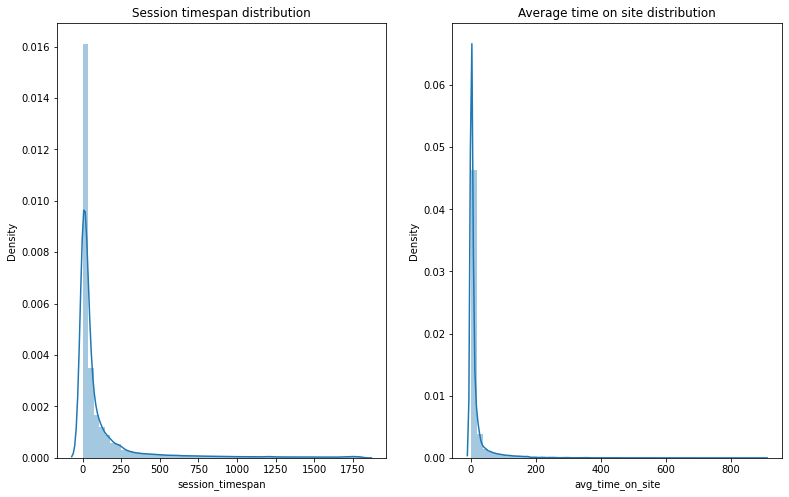

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(13, 8))
sns.distplot(train_df['session_timespan'], ax=ax[0])
sns.distplot(train_df['avg_time_on_site'], ax=ax[1])

ax[0].set_title('Session timespan distribution')
ax[1].set_title('Average time on site distribution');

So these features are indeed highly skewed. To deal with this, we will log-normalize them.

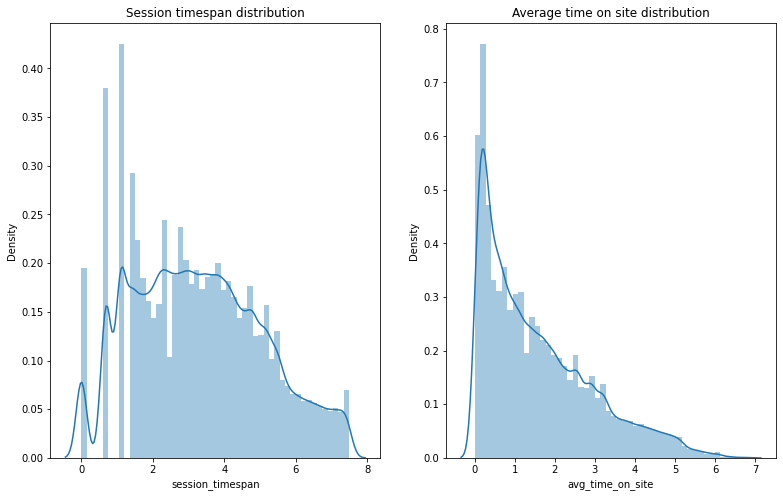

In [18]:
for df in train_df, test_df:
    df['session_timespan'] = np.log1p(df['session_timespan'])
    df['avg_time_on_site'] = np.log1p(df['avg_time_on_site'])

fig, ax = plt.subplots(1, 2, figsize=(13, 8))
sns.distplot(train_df['session_timespan'], ax=ax[0])
sns.distplot(train_df['avg_time_on_site'], ax=ax[1])

ax[0].set_title('Session timespan distribution')
ax[1].set_title('Average time on site distribution');

Before doing graphical data analysis, let's check if the introduced features are independent (by Spearman pairwise correlation).

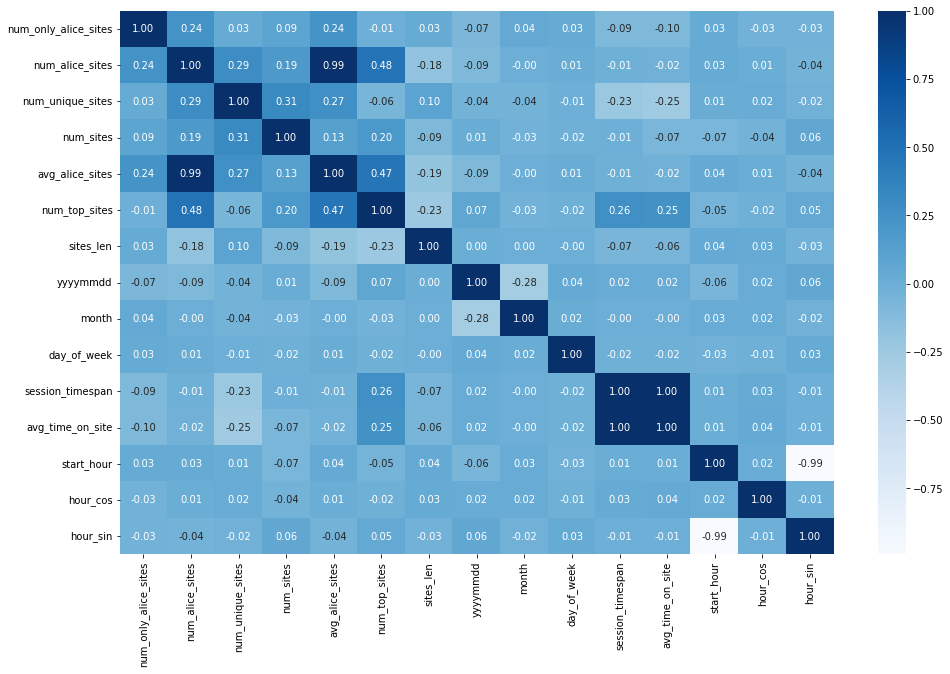

In [19]:
plt.figure(figsize = (16, 10)) 
sns.heatmap(train_df.iloc[:, 20:].corr('spearman'), annot=True, fmt='.2f', cmap='Blues');

Based on the correlation matrix, we can safely exclude `avg_alice_sites`, `avg_time_on_site` and `hour_sin` features (the last on correlating with the start hour means that the majority of the sessions begin during the day where the function $\sin(hour)$ behaves almost linearly, as we will see later). We will drop `hour_cos` as well. Some of the site features also show relatively big correlation so we'll have to be careful with them later.

In [20]:
to_drop = ['avg_alice_sites', 'avg_time_on_site', 'hour_sin', 'hour_cos']
for df in train_df, test_df:
    df.drop(to_drop, axis=1, inplace=True)

Let's draw some plots now. We will see if some features that we introduced indeed separate the two classes. Let's begin with the linear time:

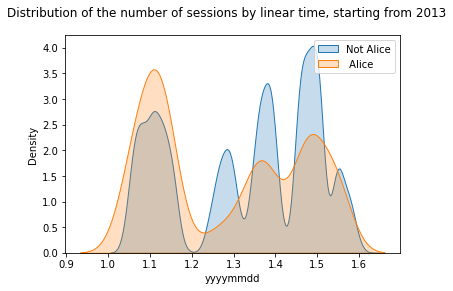

In [21]:
def plot_num_feature(feature, plot=sns.kdeplot, description=None, **plot_params):
    for i in targets.unique():
        label = 'Not' * (1 - i) + ' Alice'
        plot(train_df.loc[targets == i, feature], label=label, **plot_params)
    if description is None:    
        plt.suptitle(f'Distribution of {feature} according to the target class')
    else:
        plt.suptitle(description)
    plt.legend(loc='best');

plot_num_feature('yyyymmdd', description='Distribution of the number of sessions by linear time, starting from 2013', shade=True)

Well, at least it doesn't look like there is a linear dependence between the time and the target variable. So we'll probably have to discard this feature and binarize other linear time features, such as 'month'. Let's look at the weekday now:

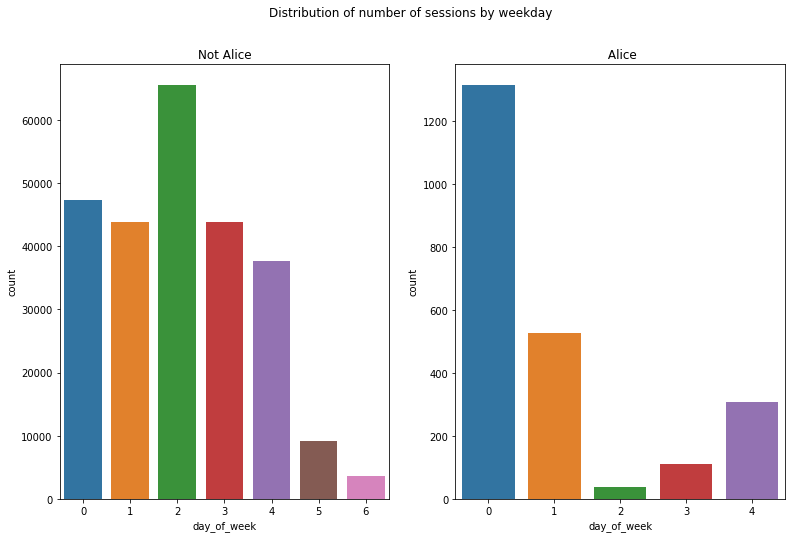

In [22]:
def plot_cat_feature(feature, plot=sns.countplot, description=None, **plot_params):
    fig, ax = plt.subplots(1, 2, figsize=(13, 8))
    for i in [0, 1]:
        plot(train_df.loc[targets == i, feature], ax=ax[i], **plot_params)
        ax[i].set_title('Not' * (1 - i) + ' Alice')

    if description is None:    
        plt.suptitle(f'Distribution of {feature} according to the feature class')
    else:
        plt.suptitle(description);


plot_cat_feature('day_of_week', description='Distribution of number of sessions by weekday')

So we see that Alice has no sessions during the weekend, and almost no sessions during Wednesday, so we might want to binarize the `day` feature and extract these days as explicit features. Let's look at the `start_hour` feature:

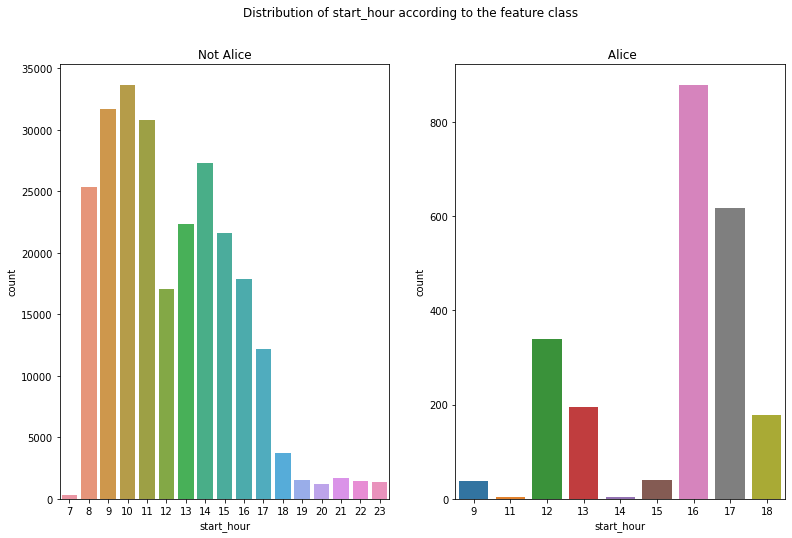

In [23]:
plot_cat_feature('start_hour')

So Alice isn't active before 9 (almost no activity until noon, in fact) and after 19. So perhaps it's better to binarize this feature as well. Let's look at the normalized session timespan:

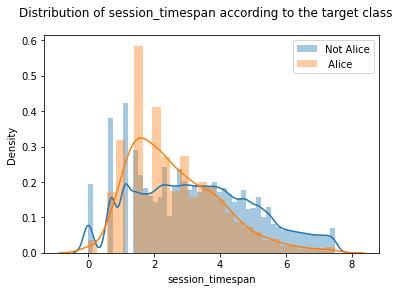

In [24]:
plot_num_feature('session_timespan', plot=sns.distplot)

It appears that Alice's sessions are generally a bit shorter. Now let's look at the site features:

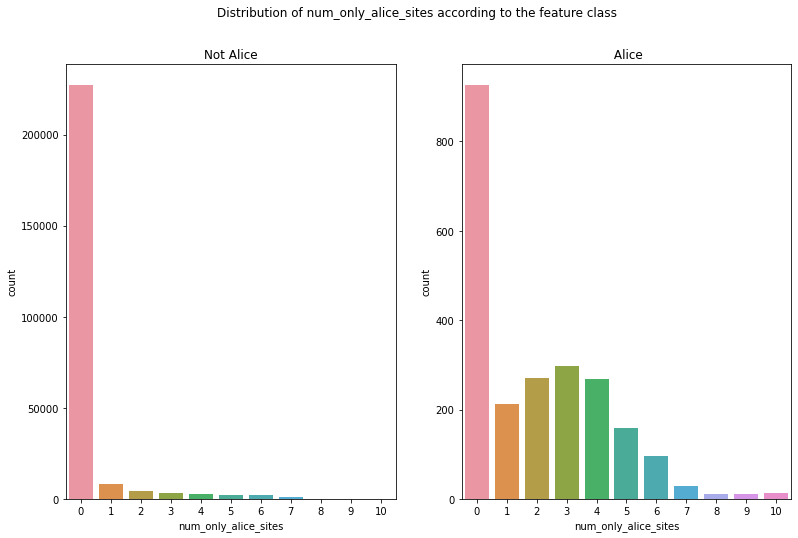

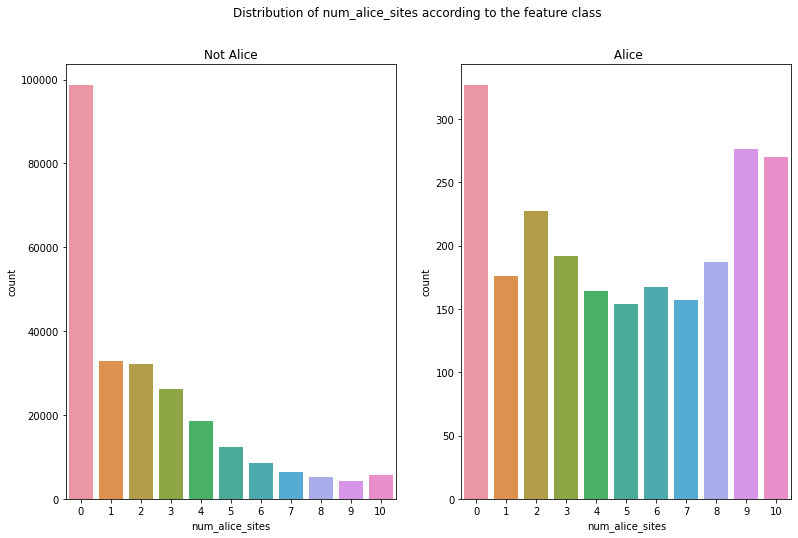

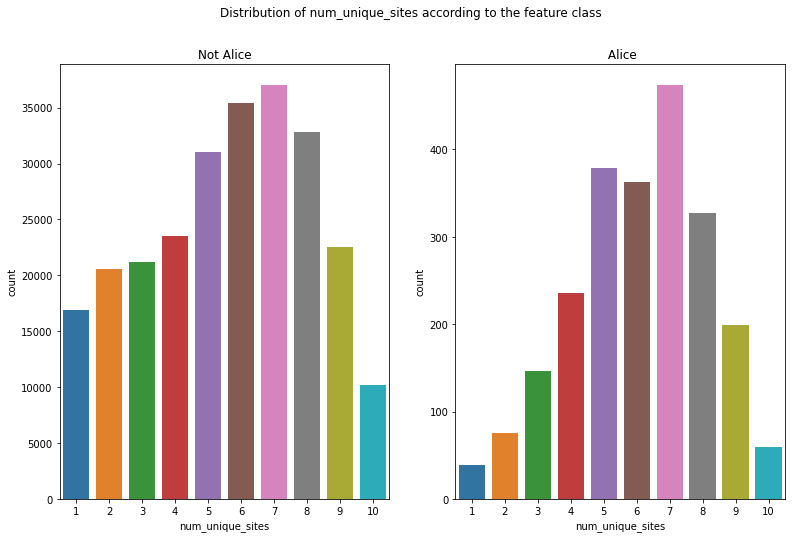

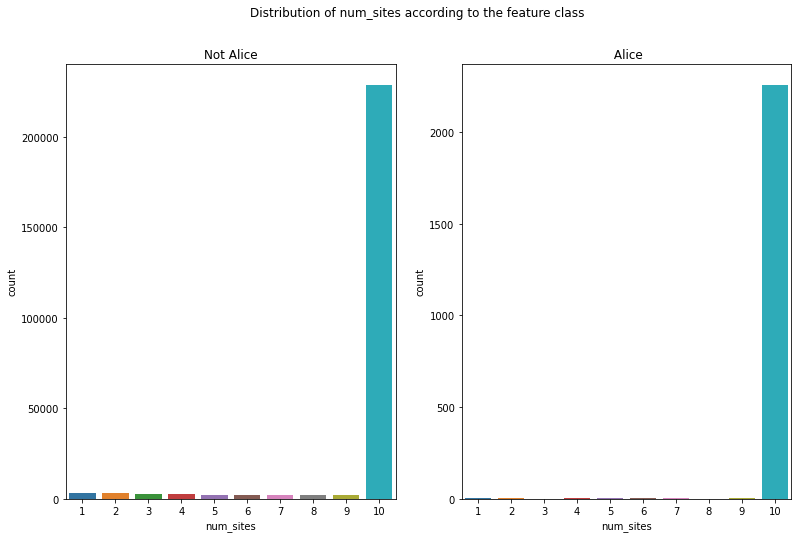

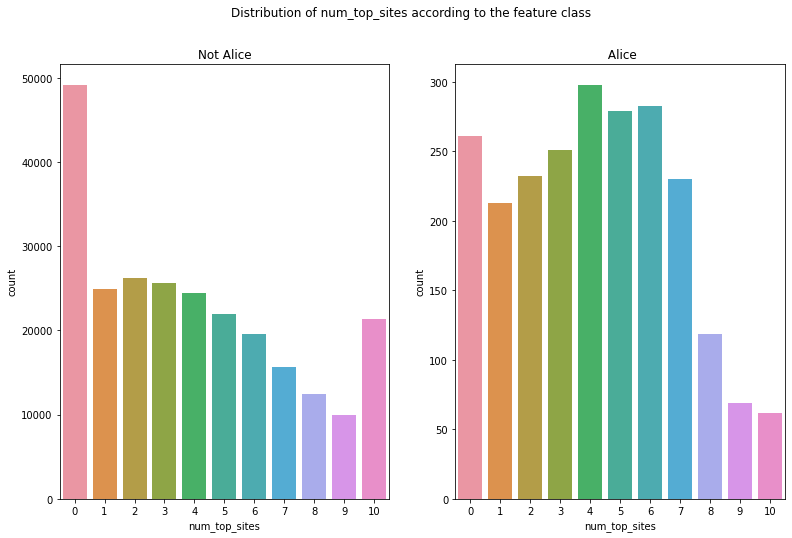

In [25]:
add_site_features = ['num_only_alice_sites', 'num_alice_sites', 
                 'num_unique_sites', 'num_sites', 'num_top_sites']

for feature in add_site_features:
    plot_cat_feature(feature)

The visual analysis suggests that the features related with number of sites from certain groups distinguish the two classes more clearly.

The distributions of visited sites lengths are almost equal, so this feature probably won't be important:

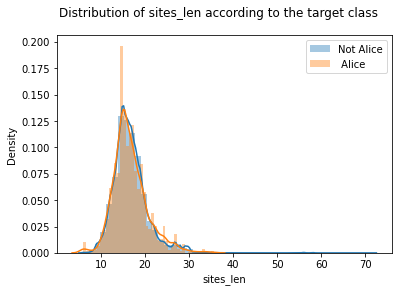

In [26]:
plot_num_feature('sites_len', plot=sns.distplot)

Now let us update the time features: we delete the linear time and binarize the cyclic time features such as month and hour. We also group some of the features together: for example, there is no point in making two separate features for two weekend days. We will also make features for time of the day (for example, for the period of 12-13 and 16-18 hours, because Alice is more active on this period. Grouping hour features may also reduce overfitting), excluding night, because there are no sessions that begin at night.

In [27]:
for df in train_df, test_df:
    df.drop(columns='yyyymmdd', inplace=True)

In [28]:
columns_to_dummies = ['start_hour','day_of_week', 'month']
train_df = pd.get_dummies(train_df, columns=columns_to_dummies, drop_first=False) # мб надо попробовать с False
test_df = pd.get_dummies(test_df, columns=columns_to_dummies, drop_first=False)

In [29]:
for df in train_df, test_df:
    df['12-13'] = ((12 <= df.time1.dt.hour) & (df.time1.dt.hour <= 13)).astype(int)
    df['16-18'] = ((16 <= df.time1.dt.hour) & (df.time1.dt.hour <= 18)).astype(int)
    df['morning'] = ((7 <= df.time1.dt.hour) & (df.time1.dt.hour <= 11)).astype(int)
    df['day'] = ((12 <= df.time1.dt.hour) & (df.time1.dt.hour <= 18)).astype(int)
    df['evening'] = ((19 <= df.time1.dt.hour) & (df.time1.dt.hour <= 24)).astype(int)
    df['is_weekend'] = df.day_of_week_5 + df.day_of_week_6 

for df in train_df, test_df:
    df.drop(columns=['day_of_week_5', 'day_of_week_6'], inplace=True)

In [30]:
add_features_train = train_df.iloc[:, 20:]
add_features_test = test_df.iloc[:, 20:]

## 3. Data model, model and metrics choice, CV scheme

We will consider the sessions as phrases in a language
where the sites URLs are words, and use the
bag of words model to represent a session as a sparse
vector. In order to preserve the temporal order of sites in a session we will also capture $n$-grams of sites for $n \le 5$ (The vectorizer parameters were chosen empirically, alternatively, we can consider $n$ as a hyperparameter and tune it at cross-validation). To emphasize the more important features we vectorize the sessions by Tf-idf and cut the number of features by 50000, so we have at least 5 train examples for each feature.

In [32]:
%%time
vectorizer_params={'ngram_range': (1, 5),
                   'max_features': 50000,
                   'tokenizer': lambda s: s.split(),
                   'sublinear_tf': True,
                   'min_df': 20,
                   }


def vectorize_sites(train_df, test_df, params):
    """Transform the sessions into sentences of the sites, fit a Tf-Idf vectorizer
    on the train data sessions and transform the test data sessions."""
    train_sessions = train_df[sites].apply(lambda row: ' '.join(site_dict[idx] for idx in row), axis=1)
    test_sessions = test_df[sites].apply(lambda row: ' '.join(site_dict[idx] for idx in row), axis=1)

    vectorizer = TfidfVectorizer(**params)
    train_sessions = vectorizer.fit_transform(train_sessions)
    test_sessions = vectorizer.transform(test_sessions)

    return vectorizer, train_sessions, test_sessions


tf_idf, X_train_sparse, X_test_sparse = vectorize_sites(train_df, test_df, vectorizer_params)
site_features = tf_idf.get_feature_names()

CPU times: user 31.8 s, sys: 1.12 s, total: 32.9 s
Wall time: 33.5 s


In [33]:
len(site_features)

28020

Now let's choose the model and CV scheme.

We will choose a linear model because they work well with the bag of words approach (a lot of sparse features). Because classes are unbalanced, we will use ROC-AUC metric to measure the effectiveness of our predictions, so we need a model that gives easily interpretable certainty coefficients, so we will use logistic regression (although we try to use SVMs as well).

We chose liblinear solver because it gave higher scores on CV.


In [34]:
logit = LogisticRegression(C=1, random_state=17, solver='liblinear')

As for the CV scheme, recall that our data has an inherent time structure that we want to preserve. So we use `TimeSeriesSplit`, a strategy that is commonly implemented when one works with time series. For each model, we compute the mean CV scores of the model and also the mean variance of the scores (to control possible overfitting). 

Update: in fact, choosing `TimeSeriesSplit` for as the CV scheme for this task seems [dubious](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/discussion/178645), but empirically we found out that this scheme correlates the most with the leaderboard. We use the `StratifiedKFold` to analyze the trends in data as well.

Some attempts to evaluate model performance that didn't work:

- Ignoring the data from 2013 completely (recall that test data is completely in 2014) — we get overfitting, see below;
- Assigning a weight to a score on `StratifiedKFold` proportional to its time intersection with test (folds with values from months from which there is more data in the test set get higher weight, yeah, overfitting, didn't work anyway);
- Shuffle split — almost no difference in scores between various configurations, good or bad.

In [35]:
time_split = TimeSeriesSplit(n_splits=10)
cv_split = StratifiedKFold(n_splits=10)

Our main tool for model evaluation is the `cross_val_scheme` function. We define some additional parameters for the function to be used later.

Instead of simply fitting the model on the whole dataset and printing the coefficients of the additional features, we tried to display the coefficients we got on validation during CV as a boxplot (like [here](https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#id5)), but this didn't lead anywhere: some features with the high variance were useful, some weren't. Moreover, for any CV split with time-contigious folds the variance of the months features will be high.

In [36]:
def cross_val_scheme(model=logit,
                     base_features=X_train_sparse,
                     base_feature_names=site_features,
                     add_features=None, # a pd.Dataframe with named columns (feature names)
                     targets=targets,
                     cv=time_split,
                     scoring='roc_auc', 
                     cutoff=None,
                     print_all_coefs=False,
                     print_add_coefs=True,
                     prefit=False):

  model_ = clone(model)

  if add_features is not None: # add new features if provided
    features = hstack([base_features, add_features]).tocsr()
    feature_names = base_feature_names + list(add_features.columns)
  else:
    features = base_features
    feature_names = base_feature_names
  
  if cutoff is not None:
    features = features[cutoff:]
    targets = targets[cutoff:]
  
  cv_results = cross_validate(model_, features, targets, scoring=scoring, cv=cv, n_jobs=-1, return_estimator=True)

  cv_scores = cv_results['test_score']
  # cv_scores = cross_val_score(model, features, targets, scoring=scoring, cv=cv, n_jobs=-1)
  print(f'CV Scores \n {cv_scores}')
  print(f'CV scores mean: {cv_scores.mean():.4f} \t CV scores std: {cv_scores.std():.4f}')

  if not prefit:
    model_.fit(features, targets)
  
  if print_all_coefs:
    display_html(eli5.show_weights(model_, feature_names=feature_names, top=30))
  
  if add_features is not None and print_add_coefs:
    coef_attr = 'coef_' if hasattr(model_, 'coef_') \
    else 'feature_importances_' if hasattr(model_, 'feature_importances_') else None
    # calculate importances of additional features if they exist
    if coef_attr is not None:
      add_coefs = pd.DataFrame({
          'feature': list(add_features.columns),
          coef_attr: getattr(model_, coef_attr).flatten()[-add_features.shape[1]:]
          })
      add_coefs.sort_values(by=coef_attr, ascending=False, inplace=True)
      print(add_coefs)
      
  return model_, cv_scores

In [37]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [38]:
len(site_features)

28020

Let's obtain a baseline model using only the data about visited sites contained in sparse matrices.

In [39]:
_, cv_scores_time1 = cross_val_scheme(print_all_coefs=True) # max_features=50000, sublinear_tf=True

CV Scores 
 [0.68422462 0.86472381 0.90091973 0.80905498 0.85485056 0.92602125
 0.73099692 0.8904301  0.91561298 0.92922192]
CV scores mean: 0.8506 	 CV scores std: 0.0801


Weight?,Feature
+5.709,cid-ed6c3e6a5c6608a4.users.storage.live.com
+5.631,info-jeunes.net
+5.449,youwatch.org
+5.252,fr.glee.wikia.com
+4.734,vk.com
+4.372,video.tt
+4.364,audienceinsights.net
+4.317,glam.com
+4.045,reviewer.lavoixdunord.fr
+4.006,melty.fr


Hmm, we have lower scores on folds №3 and №6 for some reason. Let's look at how our CV folds are distributed in time.

In [40]:
time_split_df = pd.DataFrame([train_df.iloc[list(time_split.split(X_train_sparse))[i][1]].time1.map(lambda x: x.month).value_counts() for i in range(time_split.get_n_splits())])
time_split_df = time_split_df.fillna(0).astype(int)
time_split_df.rename(columns={i: f'month_{i}' for i in range(13)}, inplace=True)
time_split_df.index = [f'fold_{i}' for i in range(time_split.get_n_splits())]
time_split_classes = pd.DataFrame([targets.iloc[list(time_split.split(X_train_sparse))[i][1]].value_counts() for i in range(time_split.get_n_splits())]).rename(columns={i: f'class_{i}' for i in range(2)})
time_split_classes.index = [f'fold_{i}' for i in range(time_split.get_n_splits())]
time_split_df = pd.concat([time_split_df, time_split_classes], axis=1)
time_split_df['CV_score1'] = cv_scores_time1
time_split_df

,month_1,month_2,month_3,month_4,month_5,month_11,month_12,class_0,class_1,CV_score1
fold_0,0,0,0,0,0,8067,14984,22809,242,0.684225
fold_1,0,0,0,0,0,0,23051,22540,511,0.864724
fold_2,17529,0,0,0,0,0,5522,22983,68,0.900920
fold_3,10529,12522,0,0,0,0,0,22913,138,0.809055
fold_4,0,23051,0,0,0,0,0,22836,215,0.854851
fold_5,0,17535,5516,0,0,0,0,22935,116,0.926021
fold_6,0,0,23051,0,0,0,0,23041,10,0.730997
fold_7,0,0,23051,0,0,0,0,22684,367,0.890430
fold_8,0,0,3657,19394,0,0,0,22988,63,0.915613
fold_9,0,0,0,22964,87,0,0,22787,264,0.929222


Ok, so the bad score on `fold_3` can perhaps be explained by the fact that the data from 2013 differs somehow from data in 2014? More precisely, it seems that the data from February is hard to predict.

So we see that there are indeed some time patterns in our data. We will see how the scores change after the introduction of additional features.

The bad score on `fold_6` can be explained by the fact that its distribution of target classes is extremely unbalanced.

Now, let's see what we get with a `StratifiedKFold`:


In [41]:
_, cv_scores1 = cross_val_scheme(cv=cv_split)

CV Scores 
 [0.86576418 0.80718474 0.92287807 0.93293997 0.81576982 0.91913097
 0.93216562 0.92018159 0.92518697 0.93561009]
CV scores mean: 0.8977 	 CV scores std: 0.0471


Again, some scores are significantly lower than average, let's see the time distribution of the folds.

In [42]:
cv_split_df = pd.DataFrame([train_df.iloc[list(cv_split.split(X_train_sparse, targets))[i][1]].time1.map(lambda x: x.month).value_counts() for i in range(cv_split.get_n_splits())])
cv_split_df = cv_split_df.fillna(0).astype(int)
cv_split_df.rename(columns={i: f'month_{i}' for i in range(13)}, inplace=True)
cv_split_df.index = [f'fold_{i}' for i in range(cv_split.get_n_splits())]
cv_split_df['CV_score1'] = cv_scores1
cv_split_df

,month_1,month_2,month_3,month_4,month_5,month_11,month_12,CV_score1
fold_0,0,0,0,0,0,25357,0,0.865764
fold_1,0,0,0,0,0,5761,19595,0.807185
fold_2,1762,0,0,0,0,0,23594,0.922878
fold_3,25127,0,0,0,0,0,229,0.932940
fold_4,1169,24048,0,0,0,0,139,0.815770
fold_5,0,25356,0,0,0,0,0,0.919131
fold_6,0,3704,21652,0,0,0,0,0.932166
fold_7,0,0,25356,0,0,0,0,0.920182
fold_8,0,0,8267,17089,0,0,0,0.925187
fold_9,0,0,0,25269,87,0,0,0.935610


Well, it seems that the data from 2013 isn't explained that well by data from 2014. Perhaps it has something to do with different target class distribution?



In [43]:
train_df[targets==1].time1.map(lambda x: x.year).value_counts()

2014    1241
2013    1056
Name: time1, dtype: int64

In [44]:
train_df.time1.map(lambda x: x.year).value_counts()

2014    178886
2013     74675
Name: time1, dtype: int64

Well, as we've already mentioned above, forgetting the data from 2013 leads to overfitting (we have better CV scores, but worse leaderboard scores, see below). You can fiddle with the `cutoff` parameter in the `cross_val_scheme` function.

In [45]:
cutoff_2013 = train_df.time1.map(lambda date: date.year).value_counts()[2013]
cutoff_2013

74675

In [46]:
_ = cross_val_scheme(cv=cv_split, cutoff=cutoff_2013)

CV Scores 
 [0.92499796 0.91457787 0.9018712  0.95668313 0.9259154  0.89854762
 0.92727771 0.93903241 0.95524657 0.92635976]
CV scores mean: 0.9271 	 CV scores std: 0.0185


We also note that the month of February (its first half?) performs poorly in cross-validation. Removing it completely from consideration wouldn't be good, because we want our data to be time-contiguous. Moreover, most of the test entries are from February 2014.

To summarize, our data is certainly time-heterogeneous, but it's not clear for now how we can put this fact to our use. Introducing time-related features will smooth the differences in CV scores.

## 4. Feature engineering

Now let's load all the additional features and see if we got an improvement.

In [47]:
_, cv_scores_time2 = cross_val_scheme(add_features=add_features_train) 

CV Scores 
 [0.80662773 0.95809654 0.97529632 0.84566321 0.97110886 0.97187441
 0.84322295 0.98314456 0.99092763 0.98791991]
CV scores mean: 0.9334 	 CV scores std: 0.0678
                 feature     coef_
37                 16-18  1.916911
24         day_of_week_0  1.437219
9           start_hour_9  1.376747
36                 12-13  0.889993
25         day_of_week_1  0.771235
16         start_hour_16  0.710162
12         start_hour_12  0.681770
17         start_hour_17  0.639132
18         start_hour_18  0.567617
34              month_11  0.459284
0   num_only_alice_sites  0.371605
13         start_hour_13  0.208223
1        num_alice_sites  0.189837
2       num_unique_sites  0.015729
39                   day  0.010953
5              sites_len -0.074219
7           start_hour_7 -0.079963
3              num_sites -0.086585
28         day_of_week_4 -0.095775
4          num_top_sites -0.132010
6       session_timespan -0.162192
20         start_hour_20 -0.227467
15         start_hour_1

In [48]:
_, cv_scores2 = cross_val_scheme(add_features=add_features_train, cv=cv_split, print_add_coefs=False)

CV Scores 
 [0.9242765  0.84696502 0.8462895  0.99406578 0.89090808 0.95306006
 0.97085593 0.99030036 0.97608194 0.99109324]
CV scores mean: 0.9384 	 CV scores std: 0.0553


The things to note from here:

- The CV means improved, but the CV stds did not improve that much — this might suggest overfitting;
- Some of the new features have big weights in the model, so we'll have to check if they simply explain the target feature that well or cause overfitting;
- The `month_11` and `month_12` features, although useful to the train set, will be useless on the test set (it is concentrated entirely in the first half of 2014), so it is better to exclude these two features.
- There are more features with the negative weight (that pull to the "not Alice" class);
- We may group some of the multicollinear features describing hour of the day, for example, `start_hour_8, start_hour_10, start_hour_11` (they have the same sign as the `morning` feature and can therefore be grouped into one), the features `start_hour_12, start_hour_13` (the same sign as the `12-13` feature) and so on;
- A lot of site-related features have almost zero weights, so we'll have to exclude (or transform into something else) some of them later.

In [49]:
to_drop = [f'start_hour_{i}' for i in [7, 8, 10, 11, 12, 13] + list(range(16, 24))] 

add_features_train.drop(columns=['month_11', 'month_12'], inplace=True)
for df in add_features_train, add_features_test:
    df.drop(columns=to_drop, inplace=True)

In [50]:
_, cv_scores_time3 = cross_val_scheme(add_features=add_features_train)

CV Scores 
 [0.82409872 0.95850382 0.97127928 0.83753227 0.97111334 0.97353803
 0.85033202 0.98319273 0.9908648  0.98769234]
CV scores mean: 0.9348 	 CV scores std: 0.0647
                 feature     coef_
21                 16-18  2.417363
7           start_hour_9  2.323814
10         day_of_week_0  1.301894
20                 12-13  1.231160
11         day_of_week_1  0.698157
23                   day  0.555854
0   num_only_alice_sites  0.363720
1        num_alice_sites  0.190555
2       num_unique_sites  0.014285
14         day_of_week_4 -0.008280
5              sites_len -0.074571
3              num_sites -0.100536
4          num_top_sites -0.130241
6       session_timespan -0.156774
9          start_hour_15 -0.404656
19               month_5 -0.471803
16               month_2 -0.550163
18               month_4 -0.605688
17               month_3 -0.876779
13         day_of_week_3 -1.047693
24               evening -1.809547
15               month_1 -2.179604
12         day_of_week_

In [51]:
_, cv_scores3 = cross_val_scheme(add_features=add_features_train, cv=cv_split, print_add_coefs=False)

CV Scores 
 [0.95009093 0.86440915 0.84421115 0.99605515 0.89658088 0.95302891
 0.97097429 0.98958467 0.97633285 0.99115069]
CV scores mean: 0.9432 	 CV scores std: 0.0524


Only a marginal improvement in both the CV scores and the deviations, but still, less features.

Now we should do some feature selection. Basically we chose additional features by hand (see our analysis below), but several approaches at automatic features selection were tried:


1. Select $k$ best additional features according to some metric. For example, we can try the following ways to evaluate the additional features:
    - Evaluate their weights using some model (we tried logit itself and random forest);
    - Use some univariate criterion (for example, compute mutual information).
*Didn't work very well, because some of the high-ranking features simply overfit the model. You can see the code for the fuctions we used in the project files*;
2. To control both the CV means and variances, use a sequential feature extractor (on the additional features only) with the metric $\alpha\cdot(\text{cv scores mean}) - (1 - \alpha)\cdot(\text{cv scores std})$ for $\alpha \in [0,1]$
*Worked mostly fine, however, some of the features don't do well at our cross-validation but do well at the Kaggle score. Might serve as a good start.*;
3. Boruta selection with random forest as the base model.
*Didn't work, chose too many features.*
4. Use logistic regression with $L_1$ regularization to reduce the number of the features (we suspect that most of the base features don't contribute much to the model).
*Substituting $L_2$ regularization by $L_1$ regularization worked, see below.*


Here are the additional features we chose by hand. We found that:
- The features with large positive coefficients, such as `12-13`, `16-18` and `day_of_week_0` indeed overfit the model (we have lower scores on both our CV and the Kaggle leaderboard), as well as some of the features with large negative coefficients (`day_of_week_3`);
- The feature `start_hour_9` gives worse score on our CV, but better score on the Kaggle leaderboard;
- Most of the site-related features don't contribute anything to the model;
- The usual `StratifiedKFold` stops correlating meaningfully with the leaderboard after some point, but we still could use it: for example, the feature `morning` improves the score on the `fold_4` of the `cv_split`, but worsens on `fold_2`, so we choose to leave this feature in the final set because again, `fold_4` intersects with the test set (perhaps not the best approach for building a good *predictive* model...) 
- Some of the months features indeed improve the quality of the model (probably due to overfitting, but that's all the data we have...). You can exclude these features and obtain a time-independent model that still has decent prediction quality.

You can find the feature coefficients and the fold-wise CV scores below.


In [52]:
selected_features_logit = ['num_only_alice_sites', 'session_timespan',
                            'start_hour_9', 'start_hour_14', 'start_hour_15', 'morning', 'evening',
                             'day_of_week_2', 'day_of_week_4', 'is_weekend',
                            'month_2', 'month_3', 'month_4']

logit, cv_scores_time4 = cross_val_scheme(add_features=add_features_train.loc[:, selected_features_logit])

CV Scores 
 [0.82870652 0.94747177 0.96272693 0.93627471 0.96518146 0.97415353
 0.93005946 0.9827991  0.98817948 0.97222283]
CV scores mean: 0.9488 	 CV scores std: 0.0439
                 feature     coef_
2           start_hour_9  2.229867
0   num_only_alice_sites  0.400770
1       session_timespan -0.117892
11               month_3 -0.237944
12               month_4 -0.348493
10               month_2 -0.367673
8          day_of_week_4 -0.910876
4          start_hour_15 -2.544046
7          day_of_week_2 -3.086143
9             is_weekend -3.366565
6                evening -3.390435
3          start_hour_14 -4.615604
5                morning -5.304028


In [53]:
time_split_df['CV_score2'] = cv_scores_time2
time_split_df['CV_score3'] = cv_scores_time3
time_split_df['CV_score4'] = cv_scores_time4
time_split_df

,month_1,month_2,month_3,month_4,month_5,month_11,month_12,class_0,class_1,CV_score1,CV_score2,CV_score3,CV_score4
fold_0,0,0,0,0,0,8067,14984,22809,242,0.684225,0.806628,0.824099,0.828707
fold_1,0,0,0,0,0,0,23051,22540,511,0.864724,0.958097,0.958504,0.947472
fold_2,17529,0,0,0,0,0,5522,22983,68,0.900920,0.975296,0.971279,0.962727
fold_3,10529,12522,0,0,0,0,0,22913,138,0.809055,0.845663,0.837532,0.936275
fold_4,0,23051,0,0,0,0,0,22836,215,0.854851,0.971109,0.971113,0.965181
fold_5,0,17535,5516,0,0,0,0,22935,116,0.926021,0.971874,0.973538,0.974154
fold_6,0,0,23051,0,0,0,0,23041,10,0.730997,0.843223,0.850332,0.930059
fold_7,0,0,23051,0,0,0,0,22684,367,0.890430,0.983145,0.983193,0.982799
fold_8,0,0,3657,19394,0,0,0,22988,63,0.915613,0.990928,0.990865,0.988179
fold_9,0,0,0,22964,87,0,0,22787,264,0.929222,0.987920,0.987692,0.972223


In [54]:
selected_features_logit = ['num_only_alice_sites', 'session_timespan',
                            'start_hour_9', 'start_hour_14', 'start_hour_15', 'morning', 'evening',
                             'day_of_week_2', 'day_of_week_4', 'is_weekend',
                            'month_2', 'month_3', 'month_4']

_, cv_scores4 = cross_val_scheme(add_features=add_features_train.loc[:, selected_features_logit], cv=cv_split, print_add_coefs=False)

CV Scores 
 [0.94470542 0.88011035 0.838226   0.98617816 0.93423511 0.98106275
 0.97190637 0.98137889 0.98663034 0.97911846]
CV scores mean: 0.9484 	 CV scores std: 0.0485


In [55]:
cv_split_df['CV_score2'] = cv_scores2
cv_split_df['CV_score3'] = cv_scores3
cv_split_df['CV_score4'] = cv_scores4
cv_split_df

,month_1,month_2,month_3,month_4,month_5,month_11,month_12,CV_score1,CV_score2,CV_score3,CV_score4
fold_0,0,0,0,0,0,25357,0,0.865764,0.924277,0.950091,0.944705
fold_1,0,0,0,0,0,5761,19595,0.807185,0.846965,0.864409,0.880110
fold_2,1762,0,0,0,0,0,23594,0.922878,0.846289,0.844211,0.838226
fold_3,25127,0,0,0,0,0,229,0.932940,0.994066,0.996055,0.986178
fold_4,1169,24048,0,0,0,0,139,0.815770,0.890908,0.896581,0.934235
fold_5,0,25356,0,0,0,0,0,0.919131,0.953060,0.953029,0.981063
fold_6,0,3704,21652,0,0,0,0,0.932166,0.970856,0.970974,0.971906
fold_7,0,0,25356,0,0,0,0,0.920182,0.990300,0.989585,0.981379
fold_8,0,0,8267,17089,0,0,0,0.925187,0.976082,0.976333,0.986630
fold_9,0,0,0,25269,87,0,0,0.935610,0.991093,0.991151,0.979118


We can arrive at roughly the same set of additional features if we choose them by a [SequentialFeatureSelector](http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/).

We choose the $\text{cv scores mean} - \text{cv scores std}$ as the metric for optimization.

In [56]:
def cv_mean_minus_cv_std(estimator, X, y):
    cv_scores = cross_val_score(estimator, X, y, scoring='roc_auc', cv=time_split, n_jobs=-1)
    return cv_scores.mean() - cv_scores.std()

In [ ]:
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector
seq_selector_logit = SequentialFeatureSelector(logit, k_features='best', forward=True, floating=True, 
                                     verbose=1, scoring=cv_mean_minus_cv_std, cv=None)
seq_selector_logit.fit(
    add_features_train.values,
    targets.values,
    custom_feature_names=list(add_features_train.columns)
)

In [ ]:
seq_selector_logit.k_feature_names_, seq_selector_logit.k_score_

(('num_only_alice_sites',
  'session_timespan',
  'start_hour_14',
  'start_hour_15',
  'day_of_week_2',
  'day_of_week_4',
  'month_1',
  'month_3',
  'day',
  'evening',
  'is_weekend'),
 0.897712832485524)

So as we expected, if we explicitly optimize the metric `cv_mean-cv_std`, then some of the highest ranking features (such as `12-13`, `16-18`) don't show up in the final features set. Some manual tweaking is still needed, however. Let's fix the final features set and make a prediction:

In [61]:
features_train = hstack([X_train_sparse, add_features_train.loc[:, selected_features_logit]]).tocsr()
features_test = hstack([X_test_sparse, add_features_test.loc[:, selected_features_logit]]).tocsr()

In [62]:
logit.fit(features_train, targets)
predicted_labels_logit1 = logit.predict_proba(features_test)[:, 1]
write_to_submission_file(predicted_labels_logit1, os.path.join(PATH_TO_DATA, 'subm_logit1.txt')) 
"""
cutoff = cutoff_2013 => 0.96059
no cutoff => 0.96283
"""

'\ncutoff = cutoff_2013 => 0.96059\nno cutoff => 0.96283\n'

## 5. Hyperparameter tuning

Finally, we tune the regularization parameter $C$. Let's plot the validation curves:

In [ ]:
from sklearn.model_selection import learning_curve, validation_curve
def plot_validation_curve(estimator, X, y, param_name, param_range, plot=plt.plot, title=None, scoring=None, ylim=None, cv=None,
                        n_jobs=None):
    
    train_scores, test_scores = validation_curve(
        estimator, X, y,
        param_name=param_name, param_range=param_range,
        scoring=scoring, cv=cv, n_jobs=n_jobs
        )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    if title is None:
      title = f'Validation curve for {estimator.__class__.__name__} with respect to {param_name}'
    plt.title(title)
    plt.grid()
    plt.xlabel(param_name)
    plt.xticks(ticks=param_range)
    plt.ylabel(str(scoring))
    if ylim is not None:
        plt.ylim(*ylim)
    lw = 2
    
    plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.2,
                    color="darkorange", lw=lw)
    
    plot(param_range, test_scores_mean, label="Cross-validation score",
                color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.2,
                    color="navy", lw=lw)
    
    plt.legend(loc="best")
    plt.show()

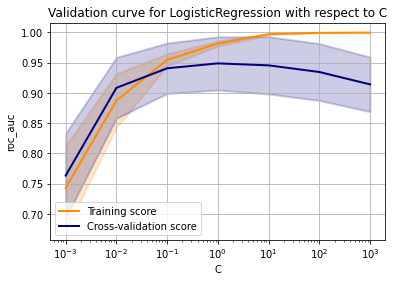

In [ ]:
plot_validation_curve(logit, features_train, targets,
                      param_name='C' , param_range=np.logspace(-3, 3, 7), cv=time_split, scoring='roc_auc',
                      plot=plt.semilogx, n_jobs=-1)

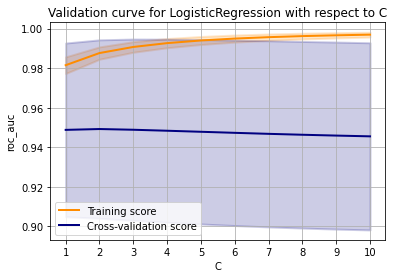

In [ ]:
plot_validation_curve(logit, features_train, targets,
                      param_name='C', param_range=np.linspace(1, 10, 10), cv=time_split, scoring='roc_auc',
                      n_jobs=-1)

So the maximum is around 2 or 3.

In [63]:
logit.C = 3
predicted_labels_logit2 = logit.predict_proba(features_test)[:, 1]
write_to_submission_file(predicted_labels_logit2, os.path.join(PATH_TO_DATA, 'subm_logit2.txt')) # 0.96452

We also try $L_1$ regularization instead of $L_2.$ The validation plots are nodescriptive in this case, and conducting a cross-validation with a high $C$ value takes too much time, so we simply train the model with a relatively high value of $C$, obtaining our best result so far:

In [ ]:
logit_l1 = LogisticRegression(penalty='l1', C=15, solver='saga', 
                                  max_iter=100, random_state=17, n_jobs=-1, verbose=2)

logit_l1.fit(features_train, targets)
predicted_labels_logit_l1 = logit_l1.predict_proba(features_test)[:, 1]
write_to_submission_file(predicted_labels_logit_l1, os.path.join(PATH_TO_DATA, 'subm_logit_l1.txt')) # 0.96663

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


max_iter reached after 1478 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 24.6min finished


## 6. Extra stuff

Some approaches that didn't work:

- Making a pipeline "$L_1$ feature selection $\Rightarrow L_2$ regularization";
- Training an SVM model;
- Applying ElasticNet regularization (it turns out that $L_1$ penalty is optimal);
- Training a random forest on a selected set of additional features (the resulting model is very unstable and depends a lot on the order of the features, even with `n_estimators=1000`);
- Making an ensemble solution of some of the solutions.

Some code can be found below.


A pipeline:

In [64]:
logit_l1 = LogisticRegression(penalty='l1', C=11, solver='saga', 
                                  max_iter=100, random_state=17, n_jobs=-1, verbose=2)
selector = SelectFromModel(logit_l1)

In [ ]:
Cs_select_lin = np.linspace(1, 10, 5)
Cs_logit_lin = np.linspace(1, 10, 5)

location = 'cachedir'
memory = Memory(location=location, verbose=10)

param_grid_lin = {
    'feature_selector__estimator__C': Cs_select_lin,
    'classifier__C': Cs_logit_lin
}

pipe_logit_lin = Pipeline(
    [('feature_selector', selector),
    ('classifier', logit)],
    memory=memory
)

grid_lin = GridSearchCV(pipe_logit_lin, scoring='roc_auc', n_jobs=-1, param_grid=param_grid_lin,
                    cv=time_split, verbose=1)

grid_lin.fit(features_train, targets)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 30.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 53.2min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 62.2min finished


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectFromModel(estimator=LogisticRegression(C=10.0, n_jobs=-1, penalty='l1',
                                             random_state=17, solver='saga',
                                             verbose=2)), 
<228204x50012 sparse matrix of type '<class 'numpy.float64'>'
	with 4341717 stored elements in Compressed Sparse Row format>, 
session_id
27554     0
81350     0
234665    0
97610     0
161358    0
         ..
207221    0
76516     0
65199     0
252772    0
157804    0
Name: target, Length: 228204, dtype: int64, 
None, message_clsname='Pipeline', message=None)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


max_iter reached after 1012 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 16.9min finished


____________________________________________fit_transform_one - 1017.2s, 17.0min


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             estimator=Pipeline(memory=Memory(location=cachedir\joblib),
                                steps=[('feature_selector',
                                        SelectFromModel(estimator=LogisticRegression(C=1,
                                                                                     n_jobs=-1,
                                                                                     penalty='l1',
                                                                                     random_state=17,
                                                                                     solver='saga',
                                                                                     verbose=2))),
                                       ('classifier',
                                        LogisticRegression(C=1, random_state=17,
                                                           solver='liblinear'))

In [ ]:
grid_lin.best_params_, grid_lin.best_score_

({'classifier__C': 3.25, 'feature_selector__estimator__C': 10.0},
 0.9463420580576412)

In [ ]:
logit_pipe = grid_lin.best_estimator_
predicted_labels_logit_pipe = logit_pipe.predict_proba(features_test)[:, 1]
write_to_submission_file(predicted_labels_logit_pipe, os.path.join(PATH_TO_DATA, 'subm_logit_pipe.txt')) #0.96447

SVM model:

In [65]:
svm = LinearSVC(random_state=17)

Cs_lin = np.linspace(0.01, 0.1, 10)
svm_cv = GridSearchCV(svm, scoring='roc_auc', n_jobs=-1, param_grid={'C': Cs_lin},
                    cv=time_split, verbose=1)
svm_cv.fit(features_train, targets)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=LinearSVC(random_state=17), n_jobs=-1,
             param_grid={'C': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ])},
             scoring='roc_auc', verbose=1)

In [66]:
svm_cv.best_params_

{'C': 0.06000000000000001}

In [67]:
svm = LinearSVC(C=0.06, random_state=17)

svm, _ = cross_val_scheme(model=svm, add_features=add_features_train.loc[:, selected_features_logit])

CV Scores 
 [0.81955289 0.92930802 0.96921382 0.93764568 0.96279579 0.97592352
 0.93699492 0.97902548 0.9875318  0.96990758]
CV scores mean: 0.9468 	 CV scores std: 0.0464
                 feature     coef_
2           start_hour_9  0.405384
0   num_only_alice_sites  0.060045
1       session_timespan -0.009258
11               month_3 -0.035817
12               month_4 -0.047414
10               month_2 -0.049249
8          day_of_week_4 -0.150189
4          start_hour_15 -0.379319
7          day_of_week_2 -0.436887
6                evening -0.496458
9             is_weekend -0.554617
3          start_hour_14 -0.725472
5                morning -0.817008


In [68]:
predicted_labels_svm = svm.decision_function(features_test)
predicted_labels_svm -= predicted_labels_svm.min()
predicted_labels_svm /= predicted_labels_svm.max()
write_to_submission_file(predicted_labels_svm, os.path.join(PATH_TO_DATA, 'subm_svm.txt')) #0.96447

Random forest model:

In [ ]:
rf = RandomForestClassifier(n_jobs=-1, max_depth=4, class_weight='balanced', n_estimators=100, random_state=17)

seq_selector_rf = SequentialFeatureSelector(rf, k_features='best', forward=False, floating=True, 
                                     verbose=1, scoring=cv_mean_minus_cv_std, cv=None)
seq_selector_rf.fit(
    add_features_train,
    targets,
    custom_feature_names=list(add_features_train.columns)
)

In [ ]:
seq_selector_rf.k_feature_names_, seq_selector_rf.k_score_ 

(('num_only_alice_sites',
  'session_timespan',
  'start_hour_14',
  'start_hour_15',
  'day_of_week_2',
  'day_of_week_4',
  'month_2',
  '12-13',
  'morning',
  'evening',
  'is_weekend'),
 0.8957908501057369)

In [121]:
selected_features_rf = seq_selector_rf.k_feature_names_

rf = RandomForestClassifier(n_jobs=-1, max_depth=4, class_weight='balanced', n_estimators=500, random_state=17)

cross_val_scheme(model=rf, base_features=None, add_features=add_features_train.loc[:, selected_features_rf], cv=time_split)

CV Scores 
 [0.83600835 0.94549329 0.94887142 0.90311636 0.91114458 0.97195316
 0.93747667 0.96964923 0.9515061  0.92616554]
CV scores mean: 0.9301 	 CV scores std: 0.0379
                 feature  feature_importances_
3                morning              0.374552
4   num_only_alice_sites              0.296664
9          day_of_week_2              0.143010
0          start_hour_14              0.078955
6       session_timespan              0.035388
1          start_hour_15              0.025199
2             is_weekend              0.017278
7                  12-13              0.011756
5                evening              0.010272
10         day_of_week_4              0.004997
8                month_4              0.001929


(RandomForestClassifier(class_weight='balanced', max_depth=4, n_estimators=500,
                        n_jobs=-1, random_state=17),
 array([0.83600835, 0.94549329, 0.94887142, 0.90311636, 0.91114458,
        0.97195316, 0.93747667, 0.96964923, 0.9515061 , 0.92616554]))

In [123]:
rf = RandomForestClassifier(n_jobs=-1, max_depth=4, class_weight='balanced', n_estimators=1000, random_state=17)
rf.fit(add_features_train.loc[:, selected_features_rf], targets)
predicted_labels_rf = rf.predict_proba(add_features_test.loc[:, selected_features_rf])[:, 1]
write_to_submission_file(predicted_labels_rf, os.path.join(PATH_TO_DATA, 'subm_rf.txt')) #0.937